The paper we're replicating (the source of the dataset that
we're be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model
architecture that they use to achieve their best results is
available here: https://arxiv.org/abs/1612.05251

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# gpu access
!nividia-smi -L

/bin/bash: nividia-smi: command not found


In [ ]:
# get data
!git clone https:///github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
#Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# starting with 20k dataset
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

import os
filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
# preprocessing
def get_lines(filename):
  '''
  Reads filename (a text filename) and returns thee 1ines of text as a list
  '''
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

In [ ]:
def processiong_text_with_lines(filename):

  input_lines = get_lines(filename) #get all lines from filename
  abstract_lines = "" #create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  #Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###") : #check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset 
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
          line_data = {} # create empty dict to store data from line
          target_text_split = abstract_line.split("\t") # split target label from text
          line_data["target"] = target_text_split[0] # get target label
          line_data["text"] = target_text_split[1].lower() # get target text and lower it
          line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
          line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
          abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  
  return abstract_samples

In [ ]:
train_samples = processiong_text_with_lines(data_dir + "train.txt")
val_samples = processiong_text_with_lines(data_dir + "dev.txt") # dev is another name for validation set
test_samples = processiong_text_with_lines(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

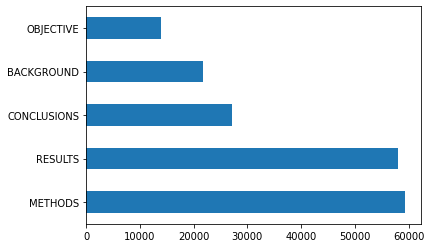

In [ ]:
train_df.target.value_counts().plot(kind='barh')

In [ ]:
train_sentences = train_df.text.to_list()
val_sentences = val_df.text.to_list()
test_sentences = test_df.text.to_list()

In [ ]:
# make numerical labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_onehot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_onehot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_onehot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_onehot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

### Model 0: Geting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ('tf-idf', TfidfVectorizer()),
                    ('clf', MultinomialNB())
])

# fit model
model_0.fit(X = train_sentences, y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# evaluate
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [ ]:
# make prediciton 
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
# compare accuracy
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-10 15:47:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-10 15:47:42 (85.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded, y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [ ]:
# prepare data for deep sequence models(vectorization and embedding)
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
#How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <a list of 30 Patch objects>)

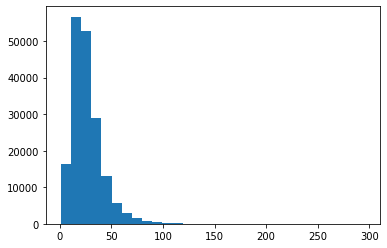

In [ ]:
plt.hist(sent_lens, bins=30)

In [ ]:
#Maximun sequence length in the training set
max(sent_lens)

296

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### Create text vectorizer
A preprocessing layer which maps text features to integer sequences.


In [ ]:
# How many words are in our vocabulary? (Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000)
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
moreover , no dose or vitamin d source was associated with modifying t@d risk factors .

Length of text: 16

Vectorized text:
[[1479   33  131   16  412  187 2962   10   81    7 6075 1990   73  254
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create Text Embedding
To create a richer numerical representation of our text, we can use an embedding.



In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, #(known as vector space) Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

In [ ]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
moreover , no dose or vitamin d source was associated with modifying t@d risk factors .

Sentence after vectorization (before embedding):
[[1479   33  131   16  412  187 2962   10   81    7 6075 1990   73  254
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.03839383 -0.02920615 -0.0100003  ...  0.02031339  0.03989835
   -0.02674136]
  [ 0.0452095  -0.00674894  0.02179397 ...  0.03592295  0.00838182
   -0.02524203]
  [-0.01550679 -0.00059284  0.0274637  ...  0.00320231 -0.01593641
   -0.00819277]
  ...
  [-0.00248803  0.02173606 -0.03675295 ... -0.0003669  -0.02840482
    0.01910147]
  [-0.00248803  0.02173606 -0.03675295 ... -0.0003669  -0.02840482
    0.01910147]
  [-0.00248803  0.02173606 -0.03675295 ... -0.0003669  -0.02840482
    0.01910147]]]

Embedded sen

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_onehot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_onehot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_onehot.shape, train_labels_onehot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

#### Prefeching

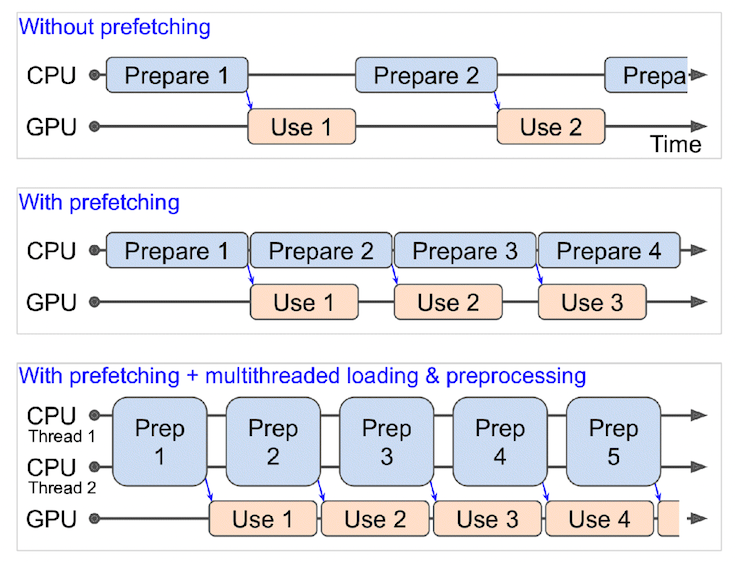

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.



In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with token embeddings
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)



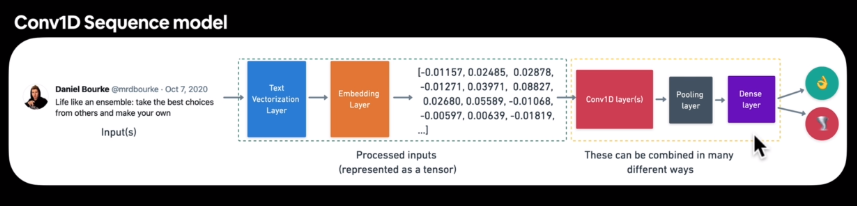

In [ ]:
len(label_encoder.classes_)

5

In [ ]:
# create 1D conv model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vector = text_vectorizer(inputs) # vectorize text inputs
token_embedding = token_embed(text_vector) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embedding)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(len(label_encoder.classes_), activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [ ]:
len(train_dataset), 0.5 * len(train_dataset)

(5627, 2813.5)

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.5 * len(train_dataset)), # only fit on 50% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.5 * len(valid_dataset))) # only validate on 50% of batches

Epoch 1/3
2813/2813 [==============================] - 24s 8ms/step - loss: 0.4799 - accuracy: 0.8334 - val_loss: 0.5400 - val_accuracy: 0.8077
Epoch 2/3
2813/2813 [==============================] - 25s 9ms/step - loss: 0.4590 - accuracy: 0.8397 - val_loss: 0.5326 - val_accuracy: 0.8092
Epoch 3/3
2813/2813 [==============================] - 1s 461us/step - loss: 0.6986 - accuracy: 0.6250 - val_loss: 0.5334 - val_accuracy: 0.8085


In [ ]:
# Evaluate on whole validation dataset (we only validated on 50% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5400 - accuracy: 0.8086


[0.5399659276008606, 0.8085529208183289]

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[7.20611393e-01, 5.05148880e-02, 9.87385064e-02, 8.19669440e-02,
        4.81682122e-02],
       [5.71606696e-01, 1.52378231e-01, 1.09173646e-02, 2.31125325e-01,
        3.39724161e-02],
       [2.03178540e-01, 7.39155617e-03, 9.80132958e-04, 7.88412333e-01,
        3.75067102e-05],
       ...,
       [1.10075837e-06, 2.26019856e-05, 9.07701498e-04, 1.02375407e-06,
        9.99067605e-01],
       [9.21898484e-02, 4.70824003e-01, 1.59453660e-01, 4.69189398e-02,
        2.30613574e-01],
       [1.09008551e-02, 9.84430850e-01, 3.95932421e-03, 1.07131185e-04,
        6.01920008e-04]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.85528928902423,
 'f1': 0.8048241713910481,
 'precision': 0.8069504758434969,
 'recall': 0.8085528928902422}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}